In [2]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [3]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()


start_t = time.time()
data_year = 'full'
pdgId = 13
category = 0
OLD_CTAU = 100 #cm
ntupler_version = 'V1p17/'
analyzer_version = 'v1/v66/'

data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v66/normalized/'
mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
Zmumu_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v42/normalized/'



fpath_bkg['data_zmu'] = Zmumu_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root'


fpath_bkg['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
fpath_bkg['mc'] = mc_path + 'ggH_HToSSTobbbb_MH-125.root'




NEvents = {}
NEvents_genweight = {}
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree_bkg[k]["weight"].array()
    print("NEvents",NEvents[k])
    print(np.sum(a))
    print(len(a))

print(time.time()-start_t)


data_zmu /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v42/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
NEvents 43150644.0
940825.0
940825
data /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v66/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root
NEvents 22763250.0
1048070.0
1048070
mc /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all/v1/v66//normalized/ggH_HToSSTobbbb_MH-125.root
NEvents 1314995700.0
48390.37
49815
5.778578519821167


# load bdt

In [12]:
# make predictions for test data

import pickle
# model = pickle.load(open( 'bdt_flatten_noEvtSelection.pickle.dat', "rb" ))
# model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1.pickle', "rb" ))

bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_XYspread_v3'

# bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs_EtaPhi_v5'
# model = pickle.load(open( 'bdt_flatten_metfilter_me1112nohits_eta2p1_testsize0p2_abs.pickle', "rb" ))
model = pickle.load(open( bdt_name+'.pickle', "rb" ))
y_pred = model.predict_proba([1,2,3,4,4,5,6])[:, 1]



# nCsc with different hit vetoing

In [4]:
%%time

start_t = time.time()
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
chamber_cut = 20
ring_cut = 50
intime = True
DPHI_CUT = 1
nDtChambers = {}
weight = {}
weight_event = {}
weight_ctau = {}
lumiSec = {}
evtNum = {}
nCsc = {}
npv = {}
npu = {}
runNum = {}
nCscRechits = {}
nCsc_JetMuonVetoCluster0p4_Me1112Veto = {}
gLLP_csc = {}

sel_ev = {}
nCscClusters = {}
nEarlyCscRechits = {}
nLateCscRechits = {}
sel_lep = {}
nCscRings = {}
nDtRings = {}
nCscDtRings = {}
cscRechitClusterSize = {}
cscRechitClusterTime = {}

cscRechitClusterTimeSpread ={}
cscRechitCluster_match_RE12_0p4={}
cscRechitCluster_match_RB1_0p4={}
cscRechitCluster_match_MB1Seg_0p4={}

cscRechitClusterEta = {}
    
    
    
cluster_index = '3'
for k,T in tree_bkg.items():

    ########### SELECTION: CLUSTERS ############
    sel_rechitcluster = np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0
    
    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < MUON_PT_CUT)
    if k[:2] == 'mc':  sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster'+cluster_index+'_match_gLLP_csc'))

        
#     cond2 = np.logical_and(np.abs( T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==2, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.6)
#     cond3 = np.logical_and(np.abs( T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==3, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.6)
#     cond4 = np.logical_and(np.abs( T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==4, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.8)
#     cond1 = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'NStation10')==1, \
#         np.logical_or(np.logical_or(np.abs( T.array('cscRechitCluster' + cluster_index + 'AvgStation10'))==1, cond2), np.logical_or(cond3, cond4)))
#     cond2 = np.logical_and(T.array('cscRechitCluster' + cluster_index + 'NStation10') > 1, np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 1.9)
#     cut_based_id = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
#     sel_rechitcluster = np.logical_and(sel_rechitcluster, cut_based_id)
    print(k, np.count_nonzero(sel_rechitcluster.flatten()))
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 50, np.abs(T.array('jetEta')) < 2.4 )

########### SELECTION: EVENTS ############
        
    if 'zmu' in k:
        sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
        sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
        sel_ev[k] = sel_lep[k].sum()>=1
        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= 50).sum()==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=120)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<200)
#         probe_index[k] = []
#         sel_tp[k] = []
#         index = 0
#         for i, ev in enumerate(sel_ev[k]):
#             if ev:
#                 if sel_lep[k][i][0]:
#                     probe_index[k].append([False,True])
#                     sel_tp[k].append(index)
#                 if sel_lep[k][i][1]:
#                     probe_index[k].append([True, False])
#                     sel_tp[k].append(index)
#                 index+=1
#         sel_tp[k] = np.array(sel_tp[k])
#         probe_index[k] = np.array(probe_index[k])
#         weight[k] = T.array('weight')[sel_ev[k]][sel_tp[k]]*lumi
#         pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][sel_tp[k]]
    else:
        sel_ev[k] = T.array('METNoMuTrigger')
#         sel_ev[k] = T.array('HLTDecision')[:,310]

        sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('met') > 200)
        sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
        sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
        sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)


    
#     sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() >= 1)
    if 'mc' in k:
        sel_ev[k] = np.logical_and(sel_ev[k], np.sum(T.array('gLLP_csc'),axis = 1) > 0)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() >= 1)
########### BRANCHES ############

   ##### event variables ##### 
    
    if k[:2] == 'mc':
        weight[k] = (T.array('pileupWeight')*T.array('weight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev[k]]
    else:
        weight[k] = np.ones(sel_ev[k].shape, dtype=bool)[sel_ev[k]]
    ##### clusters #####
    evtNum[k] =T.array('evtNum')[sel_ev[k]]
    lumiSec[k] = T.array('lumiSec')[sel_ev[k]]
    runNum[k] =T.array('runNum')[sel_ev[k]]
    nEarlyCscRechits[k] =  T.array('nEarly2CscRechits')[sel_ev[k]]
    nLateCscRechits[k] =  T.array('nLate2CscRechits')[sel_ev[k]]
    nCscClusters[k] =  T.array('nCscRechitClusters3')[sel_ev[k]]
    cscRechitClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeTotal')[sel_rechitcluster][sel_ev[k]]
    cscRechitClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_rechitcluster][sel_ev[k]]
    cscRechitClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_rechitcluster][sel_ev[k]]
    cscRechitClusterEta[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_rechitcluster][sel_ev[k]]


    cscRechitCluster_match_RE12_0p4[k] =  T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4')[sel_rechitcluster][sel_ev[k]]

    cscRechitCluster_match_RB1_0p4[k] =  T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4')[sel_rechitcluster][sel_ev[k]]
    cscRechitCluster_match_MB1Seg_0p4[k] =  T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4')[sel_rechitcluster][sel_ev[k]]



    nCscRings[k] = T.array('nDtRings')[sel_ev[k]]
    nDtRings[k] = T.array('nCscRings')[sel_ev[k]]
    nCscDtRings[k] = nCscRings[k] + nDtRings[k]

data_zmu 84
data 7264
mc 18228
CPU times: user 17.3 s, sys: 2.01 s, total: 19.3 s
Wall time: 1min 41s


## Distribution for event level variables

data 4467 4467 12.0
[[-123.78739] [-82.68925] [-47.646423] ... [-96.24049] [-26.490711] [-84.452446]]
mc 17069 17069 16461.401586272055
[[11.470463] [4.691729] [1.320165] ... [2.260555] [0.89023286] [3.6324317]]
data_zmu 19 19 19.0
[[10.569247] [5.1910863] [8.856628] ... [-11.881853] [12.461518] [-6.6731815]]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cosmics/nCscDtRings.C has been generated
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cosmics/nCscDtRings.png has been created


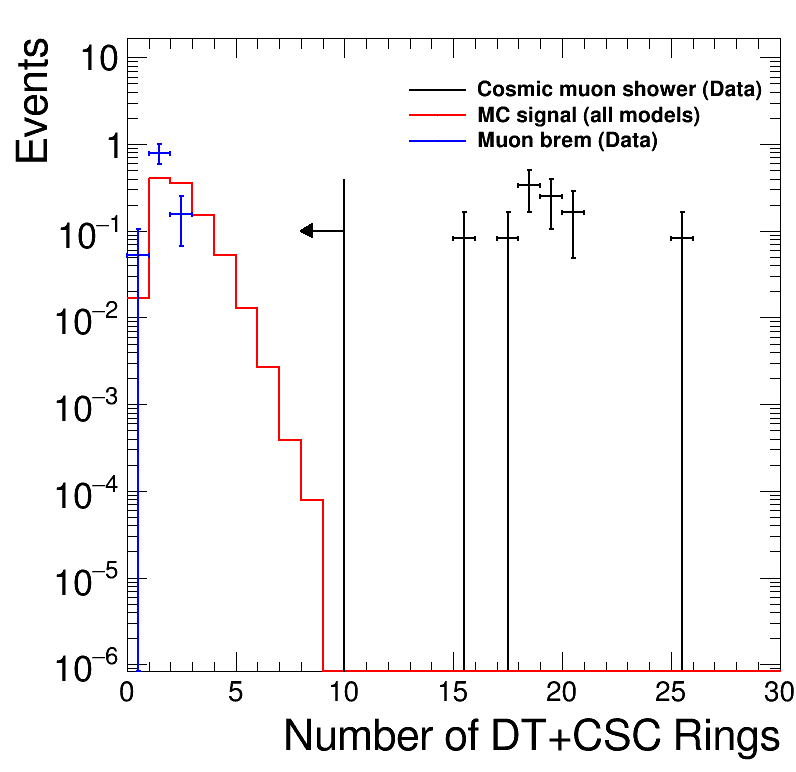

In [14]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

h = {}
rt.gStyle.SetOptFit(1011)
leg = rt.TLegend(0.5,0.8,0.9,0.9)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
keys = ['data_intime','mc_signal', 'data_oot']
keys = ['data_intime_sr','data_oot_sr','mc_sr']
keys = ['data_intime_sr','data_oot_sr',]
legend = {}
legend['data'] = 'Cosmic muon shower (Data)'
legend['mc'] = 'MC signal (all models)'
legend['data_zmu'] = 'Muon brem (Data)'
#     l.DrawLatex(0.02, 10, text+", H #rightarrow ss #rightarrow (#tau#tau)(#tau#tau)")




max_value = 0

# var = [dphiMet_cluster, nCsc_JetMuonVetoCluster0p4_Me1112Veto]
# name = ['dphiMet_cluster', 'nCsc_JetMuonVetoCluster0p4_Me1112Veto']
# xaxis = ['\Delta\Phi(cluster,MET)', 'N_{rechits}']
var = [nEarlyCscRechits, nCscDtRings]
xaxis = ['Number of Early CSC Rechits', 'Number of DT+CSC Rings']
name = ['nEarlyCscRechits', 'nCscDtRings']
bins = [30,0,15000],[30,0,30]
var_i = 1
for i,k in enumerate(['data','mc','data_zmu']):
    if var_i == 1 and k == 'data':cond = nEarlyCscRechits[k] >=3000
    else:cond = np.ones(weight[k].shape, dtype=bool)


    h[k] = create_TH1D( var[var_i][k][cond], axis_title=[xaxis[var_i], 'Events'], name=k, binning=bins[var_i], weights=weight[k][cond])
#     print(nCscClusters[k])

    print(k, len(weight[k]), len(cond),h[k].Integral())
    print(cscRechitClusterTime[k][cond])
    h[k].SetLineColor(std_color_list[i])

    if var_i == 1: h[k].SetMinimum(0.00001)
    else:h[k].SetMinimum(0.1)
    h[k].GetXaxis().SetLabelSize(0.04)
    leg.AddEntry(h[k], legend[k])
    max_value = max(h[k].GetMaximum(),max_value)
    h[k].SetMaximum(max_value*50)
    if 'data' in k:h[k].DrawNormalized('same E1')
    else:h[k].DrawNormalized("same hist")
    if var_i == 0:
        arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"|>")
        l = rt.TLine(2000,0, 2000, 0.4)
        l.SetLineWidth(2)
        arrow.SetLineWidth(2)        
        arrow.DrawArrow(2000,0.1,3000,0.1)
          
    else:
        arrow = rt.TArrow(0.5,0.5,0.5,0.5,0.02,"<|")
        l = rt.TLine(10,0, 10, 0.4)
        l.SetLineWidth(2)
        arrow.SetLineWidth(2)        
        arrow.DrawArrow(8,0.1,10,0.1)
    l.Draw()  

c.SetLogy()
leg.Draw()

c.Draw()
c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cosmics/'+name[var_i]+'.C')
c.SaveAs('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cosmics/'+name[var_i]+'.png')

# print(time.time()-start_t)

In [37]:
for k in tree_bkg.keys():
    if not k == 'data':continue
    print(k)
    cond = np.logical_and((nCscRings[k] + nDtRings[k]) < 10, nEarlyCscRechits[k]>2000)
    print(nEarlyCscRechits[k][cond], (nCscRings[k] + nDtRings[k])[cond], cscRechitClusterTimeSpread[k][cond],cscRechitCluster_match_MB1Seg_0p4[k][cond],\
          cscRechitCluster_match_RE12_0p4[k][cond],cscRechitCluster_match_RB1_0p4[k][cond], cscRechitClusterEta[k][cond], cscRechitClusterSize[k][cond])
    print(runNum[k][cond], evtNum[k][cond], lumiSec[k][cond])
#     for i,r in enumerate(runNum[k][cond]):
#         print(str(runNum[k][cond][i])+":"+str(lumiSec[k][cond][i])+":"+str(evtNum[k][cond][i]))

data
[2285 2743 2826 3395] [9 9 8 3] [[87.40955] [26.398264] [] [16.02922]] [[0] [0] [] [0]] [[6] [0] [] [0]] [[0] [0] [] [0]] [[1.0063102] [0.98847425] [] [-1.3422573]] [[361] [169] [] [4297]]
[276775 276655 319579 322348] [2141386531 1905943193 1766818240 1788857152] [1220 1087 1186 1004]
